In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests (this fetches web pages)

url = 'https://charlottesville.craigslist.org/search/fua?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape ( furniture)
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}  #this mimics a real browser request ( making sure you don't get blocked)
raw = requests.get(url) # Get page

In [81]:
from bs4 import BeautifulSoup as soup  # HTML parser
import pandas as pd

# Parse the HTML
bsObj = soup(raw.content, 'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")  # Find all listings

We'd want to use HTML tags and Classes to extract listings --> inspect page source for this information

In [82]:
from sre_constants import error
# First we need to map out furniture types ( and put them into broad categories)
fur_map = {
    # Seating
    'sofa': 'Seating', 'sofas': 'Seating',
    'couch': 'Seating', 'couches': 'Seating',
    'chair': 'Seating', 'chairs': 'Seating',
    'stool': 'Seating', 'stools': 'Seating',
    'armchair': 'Seating', 'armchairs': 'Seating',
    'recliner': 'Seating', 'loveseat': 'Seating',
    'ottoman': 'Seating', 'bench': 'Seating',
    'rocker': 'Seating', 'recliner/rocker': 'Seating',
    'glider': 'Seating','barstools': 'Seating','barstoolset': 'Seating',
    'leather':'Seating', 'lazy': 'Seating',


    # Tables
    'table': 'Table', 'tables': 'Table',
    'desk': 'Table', 'desks': 'Table',
    'dining table': 'Table', 'coffee table': 'Table', 'end table': 'Table',
    'vanity': 'Table', 'nightstand': 'Table', 'stand': 'Table', 'cart': 'Table',
    'tv':'Table', 'coffee':'Table', 'dinette':'Table',

    # Beds
    'bed': 'Bed', 'beds': 'Bed', 'bunk bed': 'Bed',
    'mattress': 'Bed', 'mattresses': 'Bed',
    'blanket': 'Bed', 'blanket sets': 'Bed',
    'pillow': 'Bed', 'pillows': 'Bed',
    'headboard': 'Bed', 'box': 'Bed',
    'bedroom': 'Bed', 'foam': 'Bed',
    'spring': 'Bed', 'twin':'Bed',

    # Storage
    'dresser': 'Storage', 'dressers': 'Storage',
    'cabinet': 'Storage', 'cabinets': 'Storage',
    'wardrobe': 'Storage', 'wardrobes': 'Storage',
    'server': 'Storage', 'hutch': 'Storage',
    'sideboard': 'Storage', 'buffet': 'Storage',
    'chest': 'Storage', 'drawers': 'Storage',
    'tv stand': 'Storage', 'tv cabinet': 'Storage',
    'china cabinet': 'Storage', 'hutch': 'Storage',
    'sideboard': 'Storage', 'server': 'Storage',
    'buffet': 'Storage', 'file cabinet': 'Storage',
    'display case': 'Storage', 'entertainment': 'Storage',

    # Shelving
    'bookshelf': 'Shelving', 'bookshelves': 'Shelving',
    'shelf': 'Shelving', 'shelves': 'Shelving',
    'rack': 'Shelving', 'racks': 'Shelving',
    'media center': 'Shelving', 'entertainment center': 'Shelving',
    'bookcase': 'Shelving', 'bookcases': 'Shelving',

    # Lighting
    'lamp': 'Lighting', 'lamps': 'Lighting',
    'light': 'Lighting', 'lights': 'Lighting',
    'chandelier': 'Lighting', 'sconce': 'Lighting',
    'candle': 'Lighting', 'wall sconces': 'Lighting',
    'fireplace': 'Lighting', 'fireplace set': 'Lighting',


    # Decor
    'mirror': 'Decor', 'mirrors': 'Decor',
    'rug': 'Decor', 'rugs': 'Decor',
    'art': 'Decor', 'prints': 'Decor',
    'chandelier': 'Decor', 'tapestry': 'Decor',
    'framed picture': 'Decor', 'wall art': 'Decor',
    'art': 'Decor', 'framed picture': 'Decor', 'print': 'Decor',
    'wall art': 'Decor', 'mantle': 'Decor',
    'tree': 'Decor', 'artwork':'Decor', 'canvas': 'Decor',

    #Appliances
    'refrigerator': 'Appliances', 'freezer': 'Appliances',
    'washer': 'Appliances', 'dryer': 'Appliances',
    'microwave': 'Appliances', 'treadmill': 'Appliances',
    'switchplates': 'Appliances', 'single-sink':'Appliances', 'door': 'Appliances', 'doors': 'Appliances',

}


location_map ={
    # Charlottesville and Nearby
    'charlottesville': 'charlottesville',
    'charlottesville - pantops': 'charlottesville',
    'charlottesville (near the uva corner)': 'charlottesville',
    'charlottesville/crozet': 'charlottesville',
    'hydraulic rd charlottesville': 'charlottesville',
    'charlottesville, va': 'charlottesville',
    'c-ville, bear buford middle': 'charlottesville',
    'pantops': 'charlottesville',
    'charlotesville': 'charlottesville',

    # Crozet and Western Albemarle
    'crozet': 'crozet',
    'crozet (old trail)': 'crozet',
    'western albemarle': 'crozet',

    # Gordonsville and Louisa County
    'gordonsville, va.': 'gordonsville',
    'gordonsville, va': 'gordonsville',
    'gordonsville': 'gordonsville',
    'louisa': 'louisa',
    'barboursville': 'gordonsville',

    # Zion Crossroads and Fluvanna County
    'zioncross roads': 'zion crossroads',
    'zion crossroads': 'zion crossroads',
    'palmyra': 'palmyra',
    'palmyra va': 'palmyra',
    'lake monticello': 'palmyra',

    # Madison and Northern Areas
    'madison': 'madison',
    'madison va': 'madison',
    'orange': 'orange',
    'reva': 'madison',

    # Waynesboro and Nearby
    'waynesboro': 'waynesboro',
    'afton': 'waynesboro',
    'lyndhurst': 'waynesboro',

    # Miscellaneous Regions
    'stanardsville': 'stanardsville',
    'bremo bluff': 'bremo bluff',
    'kents store': 'kents store',
    'scottsville': 'scottsville',
    'troy': 'troy',
    'dillwyn': 'dillwyn',
    'earlysville': 'earlysville',
    'north garden': 'north garden',
    'forest lakes': 'forest lakes',
    'hollymead': 'hollymead',
    'locust grove': 'locust grove',
    'troutville': 'troutville',
    'hood': 'hood',
    'unknown': 'unknown'

}


data=[]# # List to store extracted values

for listing in listings:
    # Extract and clean title
    title_tag = listing.find('div', class_='title')
    title = title_tag.get_text(strip=True).lower() if title_tag else "unknown" # error handling and lower case titles
    # doing lower case titles is good so we don't need to worry about uppercase when grouping/extracting.

    # Extract price with error handling
    price_tag = listing.find('div', class_='price')
    price = price_tag.get_text(strip=True) if price_tag else "unknown"

    # Extract location with error handling
    location_tag = listing.find('div', class_='location')
    location = location_tag.get_text(strip=True).lower() if location_tag else "unknown"

    # Extract link with error handling
    link_tag = listing.find('a', href=True)
    link = link_tag['href'] if link_tag else "no link available"

    # Standardizing furniture type using category mapping
    words = title.split()
    furniture_category = None
    for word in words:
        if word in fur_map:
            furniture_category = fur_map[word]
            break
    furniture_category = furniture_category if furniture_category else None  # Set None if no match

  #Standarizing location names
    location1= location_map.get(location,'unkown')


    # Append data
    data.append({'title': title, 'price': price, 'link': link, 'location': location1, 'category': furniture_category})

# Create DataFrame
df = pd.DataFrame(data)

# Let's clean the Price column in the dataframe
# we want to get rid of the dollar sign and any commas we have
df['price']= df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price']=pd.to_numeric(df['price'], errors='coerce')

# Now handling missing values
df['location'].replace('unknown', None)
df['category'].replace('missing', None)

#viewing the newly cleaned/scraped data
print(df.info())
print(df['category'].value_counts())
print(f"Number of recorded categories: {df['category'].count()}")
print(df['price'].describe())
print(df.isnull().sum())
print(df['location'].value_counts())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     356 non-null    object
 1   price     356 non-null    int64 
 2   link      356 non-null    object
 3   location  356 non-null    object
 4   category  314 non-null    object
dtypes: int64(1), object(4)
memory usage: 14.0+ KB
None
category
Table         103
Seating        75
Decor          40
Bed            29
Storage        26
Lighting       20
Shelving       13
Appliances      8
Name: count, dtype: int64
Number of recorded categories: 314
count     356.000000
mean      170.449438
std       323.912734
min         0.000000
25%        30.000000
50%        75.000000
75%       171.250000
max      2800.000000
Name: price, dtype: float64
title        0
price        0
link         0
location     0
category    42
dtype: int64
location
charlottesville    106
palmyra             66
unknown             5

FURNITURE TYPE

After looking at the description and data- we can say that there was atleast one item on the page that was free - min-0. and the mean price across the items was 170- which tells us that items posted tend to be on the pricey side.

From this statistics/information so far, we know that we scraped 356 (titles), which means every listing has a title, price, link, and location. However, 42 listings are ambigous (not in the dictionary list I wrote out)

We can see that the mean price for furniture on craig's list is 169 , and as median (50% quantile)- possibly indicating high priced items (skewed) (75). The maximum price is 2800. The statistics also gave us standard deviation of 326 ( which means we have a high variation of prices).


LOCATION

After looking at the description of our location data, I noticed that there was 304/356 of the locations were known and mapped under a common region. That being said, 52 items didn't have a location listed on the page so I placed them under the unknown category. I'll explain more detailed about the distrubtion of data, but for right now, I obsevred that charlottesville has the most items posted- it makes sense because most of these locations are within a 50 mile radius of Charlottesville.


In [83]:
# we can activley use this to see which of the titles were left uncategorized
uncategorized_items = df[df['category'].isna()]['title']
print(uncategorized_items.unique())  # See unique uncategorized furniture types

['3-tier glass television stand!' 'professional furniture reupholstering'
 'no closet solutions.' 'puritan china estate japan 46 pieces'
 'pitcher and bowl sets by ironstone u.s.a'
 'solian ware by soho pottery ltd.' 'estate sale. friday 2/7 10:00 - 2:00'
 'media center' 'exquisit display case' 'antique washstand/mirror'
 'metal twin-queen frame' 'kidkraft desk/hutch' 'heavy framed picture'
 'framed picture' 'kids desk/chair' 'old bicycle from 70s'
 'solid oak file cabinets/desk top grouping'
 'pottery barn camp corner unit' 'herman miller caper mesh chair(s)'
 'small red storage container top' 'miele rotary iron b890'
 '2 framed pictures' 'wood frame train station picture'
 'open solid wood book case' 'specialized speedster road bike'
 'free furniture' 'schwinn adult voyager bike'
 'mountain bike with accessory bag' 'yosuda excersie bike' 'barstool set'
 'dining room set' 'outdoor wicker furniture'
 'beautiful formal dining room set' "dvd caddy's   each"
 'elegant formal dining room s

In [84]:
#These are the entries with no location showed
print(df[df['location'] == 'unknown'])

                                                 title  price  \
3                                   farmhouse tv stand     75   
17                            lazy boy recliner/rocker   1000   
61                wood top end table with hairpin legs     40   
64                                        media center    300   
65                                      leather stools    150   
85                            antique washstand/mirror    250   
86                          twin size piece foam/cover     50   
87                                            wall art     20   
90                                  small refrigerator     35   
91                              metal twin-queen frame     30   
93                     brookhaven solid wood end table    150   
94              vintage keller furniture server buffet    325   
95                        early american china cabinet    300   
96                                    swivel bar stool     10   
98                       

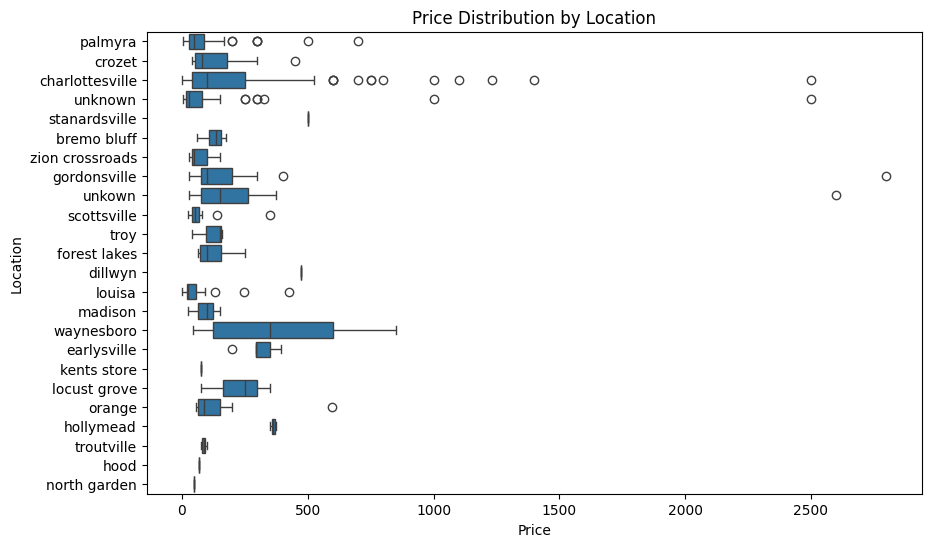

In [85]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='location', x='price', data=df)
plt.title('Price Distribution by Location')
plt.xlabel('Price')
plt.ylabel('Location')
plt.xticks()
plt.show()

The plot above shows the price distribution by location -showing the diversity/distribution in the different areas. Based on the graph, we can see that charlottesville has the most outliers. This makes sense because charlottesville did have the most items. I was surprised to see the boxplot of waynesboro ( with having only 5 items), it has extreme outliers and prices going beyon $1000. This tells us that high-priced furniture items ( maybe sofa/tables). We can aslo see that some of the areas like Forest Lakes and Zio Crossroads have a tight price distrubiton ( indicating furniture prices being more consistent). We can aslo see that several locations display a right-skewed distribution- which means that most items tend to be on the lower side of price and only a few expensive items are pulling on the average up.   

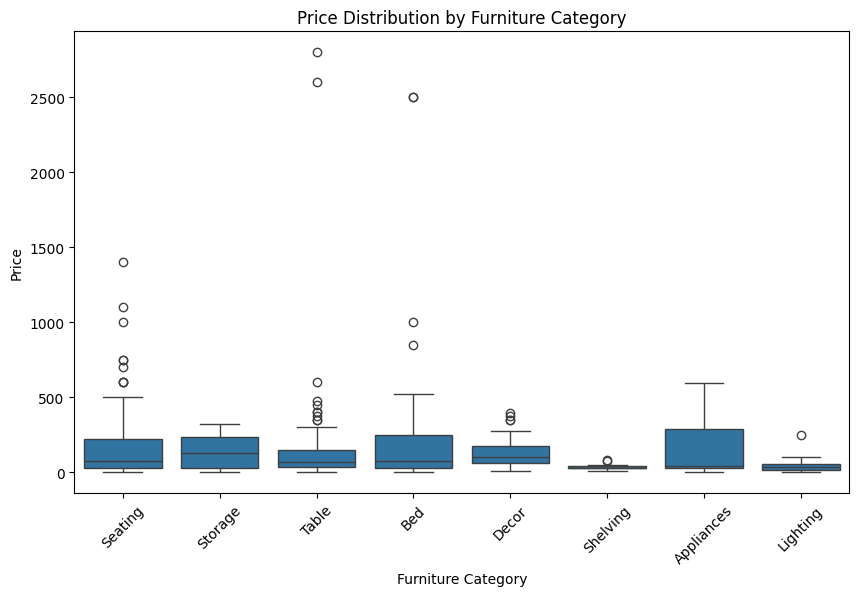

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='price', data=df)
plt.title('Price Distribution by Furniture Category')
plt.xlabel('Furniture Category')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

This plot above is yet another boxplot, but it shows the distribution of the Price by furniture category- types. In this case we can see that items like seating has the highest price range ( few being the outliers) ( right- skewed). It looks like Table, Seating and Bed tend to have more outliers ( high priced items)- which makes sense because those items could be made from unique and expenisve material like leather, bronze, or it could be antiques. This data tells us a story because by analzying the price disturbution in location and understand the local market dynamics ( which areas have more compeition/demand)

<function matplotlib.pyplot.show(close=None, block=None)>

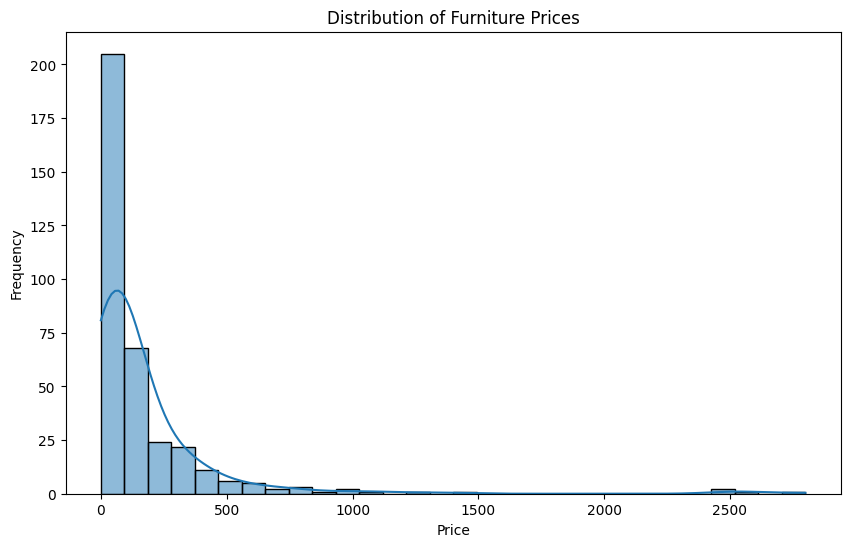

In [87]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Furniture Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show

The is a simple histogram plot that displays the frequnecy of prices. By this data we can further support the idea that most of these data are positively skewed ( having low prices). It looks looks like most items on craigslist is below $500. Which is important to know because if someone wanted to know if craiglist items are gnerally cheap or expensive, consulting with this graph allows one to understand that items posted on page tend to be cheap.  

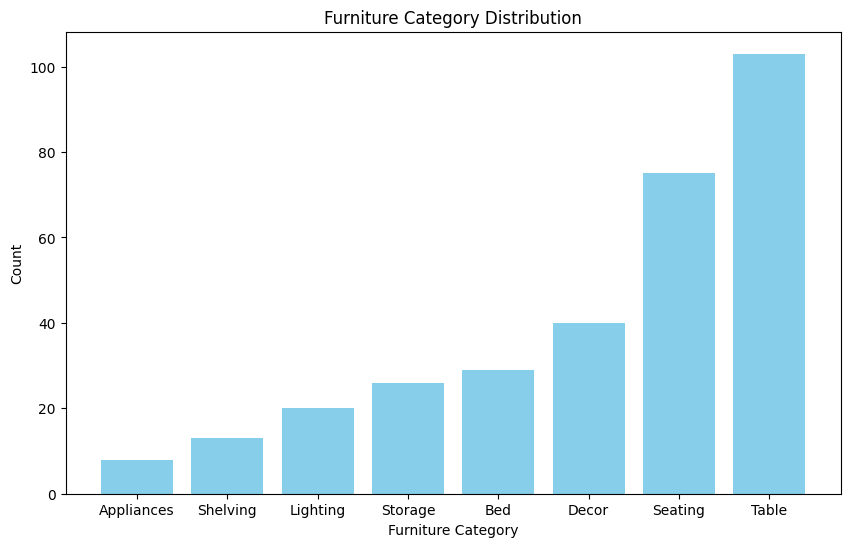

In [88]:
plt.figure(figsize=(10, 6))
sort= df['category'].value_counts().sort_values(ascending=True)
plt.bar(sort.index, sort.values, color='skyblue')
plt.title('Furniture Category Distribution')
plt.ylabel('Count')
plt.xlabel('Furniture Category')
plt.show()

This graph is interesting to me because not only does it display the type of furniture one could likely find on craigslist, but it also allows one to assume that a certain product with higher counts are more in demand. For example, the table and seating type tend to have the highest count- this could be explained by the item being in more demand/ likely to be purchased. Furthermore, appliances ( being the lowest frequncy), allows one to believe that those items are not in demand and not popular.

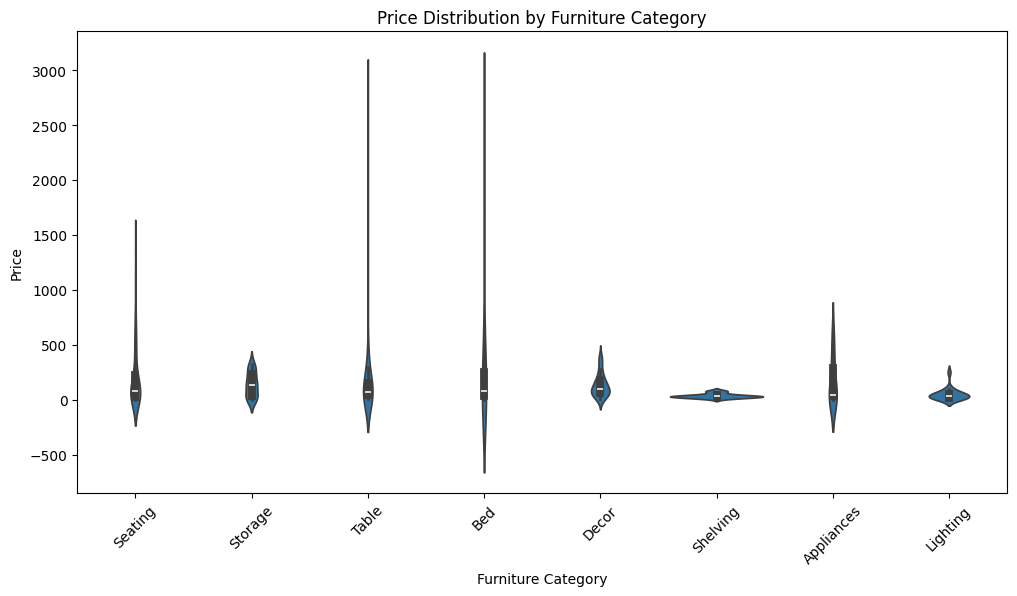

In [89]:

# Violin plot (similar to box plot but adds distribution shape)
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='category', y='price')
plt.title('Price Distribution by Furniture Category')
plt.xlabel('Furniture Category')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


This violin plot is very similar visual components as the historgram/boxplot, but the message is different. For instance, we can clearly see that table and bed have the largest distribution of data ( displayed by the long stride). But something I didn't notice from boxplot and histogram was that shelving and lighting appear have a higher denisty of lower prices ( and no long strides)- which indicates that those prices are consistent. Also, some of the types ( bed) have a distribution stride in the negatives ( which could mean preprocessing error).

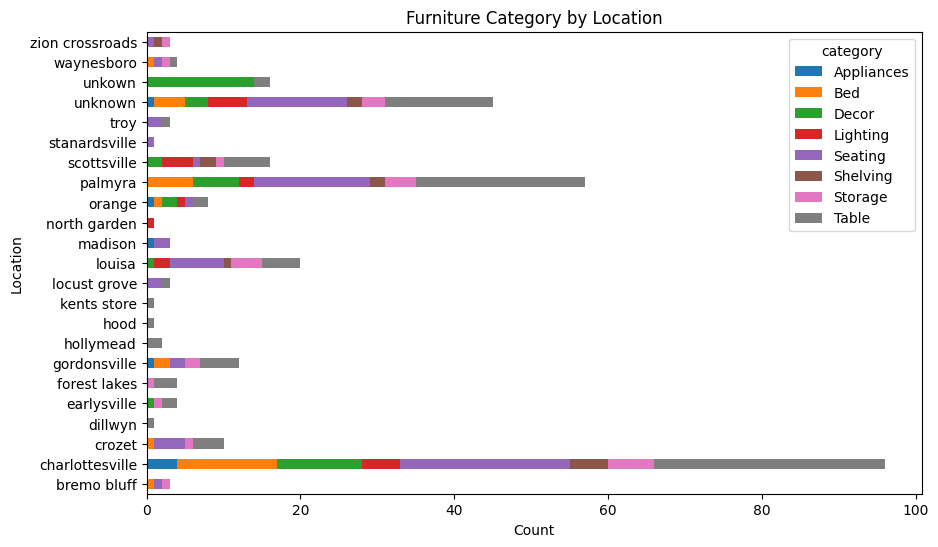

In [90]:
cat_loc= df.groupby(['location', 'category']).size().unstack()
cat_loc.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Furniture Category by Location')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

Lastly, we have a stacked barplot which tells us that in most location storage and table furniture types tend to be the most posted- which again tells us that the local market dynamics and further supports the demand for storage items and tables. Finally, I noticed that decor and applicances aren't that popular across the different location ( indicating that some areas don't have a demand for those items and tends not to post them).